In [1]:
import requests
import pandas as pd
%matplotlib inline

In [2]:
keytrans = {
    'id': 'serieid',
    'uom': 'serieunits',
    'station.properties.id': 'siteid',
    'station.properties.label': 'sitekey',
    'station.geometry.coordinates': 'geom',
    'firstValue.timestamp': 'start',
    'lastValue.timestamp': 'stop',
    #'parameters.feature.id': 'featureid',
    #'parameters.feature.label': 'featurekey',
    'parameters.phenomenon.id': 'measureid',
    'parameters.phenomenon.label': 'measurekey',
    #'parameters.category.id': 'categoryid',
    #'parameters.category.label': 'categorykey',
    #'statusIntervals': 'status'
}

In [3]:
def getMeta():
    # Download Timeserie Metadata:
    url = "https://geo.irceline.be/sos/api/v1/{target:}/?expanded=true"
    rep = requests.get(url.format(target='timeseries'))
    df = pd.io.json.json_normalize(rep.json())
    # Clean columns:
    df = df.loc[:,keytrans.keys()].rename(columns=keytrans)
    # Casts & postprocessing
    df['start'] = pd.to_datetime(df['start'], origin='unix', unit='ms')
    df['stop'] = pd.to_datetime(df['stop'], origin='unix', unit='ms')
    df['sitename'] = df['sitekey'].apply(lambda x: "-".join(x.split('-')[1:]))
    df['sitekey'] = df['sitekey'].apply(lambda x: x.split('-')[0].strip())
    df['lat'] = df['geom'].apply(lambda x: x[0])
    df['lon'] = df['geom'].apply(lambda x: x[1])
    return df.loc[:,['serieid', 'siteid', 'measureid', 'serieunits', 'measurekey', 'sitekey',
                     'sitename', 'lat', 'lon', 'start', 'stop']]

In [4]:
meta = getMeta()
meta.sample(5)

,serieid,siteid,measureid,serieunits,measurekey,sitekey,sitename,lat,lon,start,stop
233,7110,1213,38,µg/m³,Nitrogen monoxide,44R740,Sint-Kruiswinkel,3.808735,51.150136,2012-05-31 01:00:00,2020-03-10 08:00:00
224,7031,1198,38,µg/m³,Nitrogen monoxide,44M705,Roeselare,3.152402,50.945359,2012-06-03 01:00:00,2020-03-10 12:00:00
63,7129,1217,10,mg/m³,Carbon Monoxide,45R501,Charleroi,4.452172,50.409311,2012-05-31 01:00:00,2020-03-10 12:00:00
135,7026,1196,8,µg/m³,Nitrogen dioxide,44M702,Ertvelde,3.762137,51.166023,2011-01-01 01:00:00,2020-03-10 12:00:00
115,6826,1158,8,µg/m³,Nitrogen dioxide,42R830,Doel,4.262634,51.318229,2011-01-01 01:00:00,2020-03-10 11:00:00


In [5]:
def getData(series, start=None, stop=None):
    # Default Parameters:
    if isinstance(series, int):
        series = [series]
    elif isinstance(series, pd.DataFrame):
        series = list(series['serieid'])
    if stop is None:
        stop = pd.Timestamp.utcnow()
    if start is None:
        start = stop - pd.Timedelta("14 days")
    stop = pd.Timestamp(stop)
    start = pd.Timestamp(start)
    # Download Timeserie Data:
    dfs = []
    for sid in series:
        url = "https://geo.irceline.be/sos/api/v1/timeseries/{serieid:}/getData/?timespan={start:%Y-%m-%dT%H:%MZ}/{stop:%Y-%m-%dT%H:%MZ}&force_latest_values=true"
        rep = requests.get(url.format(serieid=sid, start=start, stop=stop))
        df = pd.DataFrame(rep.json()['values'])
        df['stop'] = pd.to_datetime(df['timestamp'], origin='unix', unit='ms')
        df['start'] = df['stop'] - pd.Timedelta('1H')
        df['serieid'] = sid
        df['value'] = df['value'].astype(float)
        dfs.append(df)
    if dfs:
        return pd.concat(dfs)

In [6]:
q = meta['sitekey'].str.startswith('41') & meta['measurekey'].str.lower().str.contains('nitrogen dioxide')
sel = meta.loc[q,:]
sel

,serieid,siteid,measureid,serieunits,measurekey,sitekey,sitename,lat,lon,start,stop
72,10614,1711,8,µg/m³,Nitrogen dioxide,41B008,Brussel (Beliardstraat),4.376149,50.840789,2012-11-12 13:00:00,2020-03-10 12:00:00
93,6504,1109,8,µg/m³,Nitrogen dioxide,41B001,Arts-Loi,4.368681,50.845715,2017-01-14 01:00:00,2020-03-10 12:00:00
94,6508,1110,8,µg/m³,Nitrogen dioxide,41B004,Bruxelles (Sainte-Catherine),4.348587,50.850811,2011-01-01 01:00:00,2020-03-10 12:00:00
95,6516,1112,8,µg/m³,Nitrogen dioxide,41B006,Bruxelles (Parlement UE),4.374388,50.838631,2011-01-01 01:00:00,2020-03-10 12:00:00
96,6528,1113,8,µg/m³,Nitrogen dioxide,41B011,Berchem-Sainte-Agathe,4.288336,50.858031,2011-01-01 01:00:00,2020-03-10 12:00:00
97,6551,1116,8,µg/m³,Nitrogen dioxide,41MEU1,Meudon,4.392718,50.895101,2011-09-23 12:00:00,2020-03-10 12:00:00
98,6561,1117,8,µg/m³,Nitrogen dioxide,41N043,Haren,4.382963,50.883560,2011-01-01 01:00:00,2020-03-10 12:00:00
99,6574,1118,8,µg/m³,Nitrogen dioxide,41R001,Molenbeek-Saint-Jean,4.333820,50.849665,2011-01-01 01:00:00,2020-03-10 12:00:00
100,6615,1119,8,µg/m³,Nitrogen dioxide,41R002,Ixelles,4.384719,50.825128,2011-01-01 01:00:00,2020-03-10 12:00:00
101,6622,1122,8,µg/m³,Nitrogen dioxide,41R012,Uccle,4.358539,50.796632,2011-01-01 01:00:00,2020-03-10 12:00:00


In [7]:
recs = getData(sel, start='2020-03-01', stop='2020-03-10')
recs.sample(5)

,timestamp,value,stop,start,serieid
139,1583521200000,16.5,2020-03-06 19:00:00,2020-03-06 18:00:00,6528
129,1583485200000,34.5,2020-03-06 09:00:00,2020-03-06 08:00:00,6561
22,1583100000000,18.5,2020-03-01 22:00:00,2020-03-01 21:00:00,6615
40,1583164800000,64.0,2020-03-02 16:00:00,2020-03-02 15:00:00,6504
11,1583060400000,8.0,2020-03-01 11:00:00,2020-03-01 10:00:00,6516


In [8]:
data = recs.merge(sel.loc[:,['serieid', 'sitekey', 'serieunits']])\
           .pivot_table(index='start', columns=['sitekey', 'serieunits'], values='value')
data.sample(5)

sitekey,41B001,41B004,41B006,41B008,41B011,41MEU1,41N043,41R001,41R002,41R012,41WOL1
serieunits,µg/m³,µg/m³,µg/m³,µg/m³,µg/m³,µg/m³,µg/m³,µg/m³,µg/m³,µg/m³,µg/m³
start,,,,,,,,,,,
2020-03-04 16:00:00,69.5,33.5,32.0,95.0,12.5,21.0,53.0,38.5,40.0,8.5,27.5
2020-03-06 16:00:00,87.0,30.5,NaN,NaN,8.5,9.5,12.0,43.0,46.0,10.0,38.0
2020-03-01 13:00:00,41.5,NaN,11.0,33.5,NaN,10.5,13.5,11.5,18.5,3.5,6.5
2020-03-09 23:00:00,12.5,11.5,8.5,26.0,0.0,7.0,12.0,4.5,8.0,2.0,4.0
2020-03-02 09:00:00,45.5,NaN,23.5,69.0,15.0,21.5,41.0,23.5,34.5,6.0,24.0


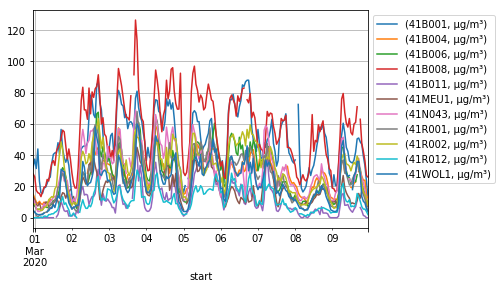

In [9]:
axe = data.plot()
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()